# Timestamp creation
***

## Workflow
1. Imports
2. Speech-to-text with google API
3. Match google transcript sentences to MIT sentences
4. Create timestamps for MIT sentences
5. Apply to all interviews and save

## 1. Imports

In [ ]:
!pip3 install SpeechRecognition pydub
# importing libraries 
import speech_recognition as sr 
import os 
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
import itertools
import re


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

import sys

nltk.download('punkt')

# create a speech recognition object
r = sr.Recognizer()
from google.colab import drive
drive.mount('/content/drive')

## 2. Speech-to-text with google API

Transcribe audio with only the interviewee

- split the audiofile into chunks that are small enough for google (sentence level)
- transcribe each chunk
- save the transcripts for later use the process takes quite long

In [ ]:
# function from pyhub https://github.com/jiaaro/pydub/blob/master/pydub/silence.py#L78 adapted
def split_on_silence(audio_segment, min_silence_len=1000, silence_thresh=-16, keep_silence=100,
                     seek_step=1):
    """
    Returns list of audio segments from splitting audio_segment on silent sections
    audio_segment - original pydub.AudioSegment() object
    min_silence_len - (in ms) minimum length of a silence to be used for
        a split. default: 1000ms
    silence_thresh - (in dBFS) anything quieter than this will be
        considered silence. default: -16dBFS
    keep_silence - (in ms or True/False) leave some silence at the beginning
        and end of the chunks. Keeps the sound from sounding like it
        is abruptly cut off.
        When the length of the silence is less than the keep_silence duration
        it is split evenly between the preceding and following non-silent
        segments.
        If True is specified, all the silence is kept, if False none is kept.
        default: 100ms
    seek_step - step size for interating over the segment in ms
    """

    # from the itertools documentation
    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    if isinstance(keep_silence, bool):
        keep_silence = len(audio_segment) if keep_silence else 0

    output_ranges = [
        [ start - keep_silence, end + keep_silence ]
        for (start,end)
            in detect_nonsilent(audio_segment, min_silence_len, silence_thresh, seek_step)
    ]

    for range_i, range_ii in pairwise(output_ranges):
        last_end = range_i[1]
        next_start = range_ii[0]
        if next_start < last_end:
            range_i[1] = (last_end+next_start)//2
            range_ii[0] = range_i[1]
    
    
    audio_out = [audio_segment[ max(start,0) : min(end,len(audio_segment)) ]
        for start,end in output_ranges]

    #print(f'Split on silence - shape audio output: {np.shape(audio_out)}')
    #print(f'Split on silence - Timestamps : {np.shape(output_ranges)}')

    return audio_out, output_ranges

In [ ]:
# a function that splits the audio file into chunks
# and applies speech recognition
def get_large_audio_transcription(path):

    # open the audio file using pydub
    sound = AudioSegment.from_wav(path)
    
    # split audio sound where silence is 700 miliseconds or more and get chunks
    chunks, time_stamps = split_on_silence(sound,
        # experiment with this value for your target audio file {500 was standard}
        min_silence_len = 600,
        # adjust this per requirement
        silence_thresh = sound.dBFS-14,
        # keep the silence for 1 second, adjustable as well
        keep_silence=500,
    )
    folder_name = "audio-chunks"
    # create a directory to store the audio chunks
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    #whole_text = ""
    sentence_list = []
    # process each chunk 
    for i, audio_chunk in enumerate(chunks, start=1):
        # export audio chunk and save it in
        # the `folder_name` directory.
        chunk_filename = os.path.join(folder_name, f"chunk{i}.wav")
        audio_chunk.export(chunk_filename, format="wav")
        # recognize the chunk
        with sr.AudioFile(chunk_filename) as source:
            audio_listened = r.record(source)
            # try converting it to text
            try:
                text = r.recognize_google(audio_listened)
            except sr.UnknownValueError as e:
                time_stamps[i-1] = []
                #print("Error:", str(e))
            else:
                text = f"{text.capitalize()}."
                #print(chunk_filename, ":", text)
                #whole_text += text
                sentence_list.append(text)
    # return the text for all chunks detected
    time_stamps[:] = [item for item in time_stamps if item != []]
    
    #print(f'After speech to text - whole text split: {np.shape(sentence_list)}')
    #print(f'After speech to text - Timestamps : {np.shape(time_stamps)}')
    
    return sentence_list, time_stamps

In [ ]:
download = False

if download:
  audio_file_dir = 'drive/MyDrive/Colab Notebooks/XAI/audio_split/Code'
  audio_file_names = os.listdir(audio_file_dir)

  transcripts_list = []
  timestamps_list = []
  participant_list = []

  for i, name in enumerate(audio_file_names):
    full_path = audio_file_dir + '/' + name

    print(f'Interview: {name}')
    if i < 200:
      participant = re.sub(".wav[\s\S]*", "", name).lower()
      participant_list.append(participant)
      try: 
        transcript, timestamps = get_large_audio_transcription(full_path)
      except:
        print(f'Error occured at: {i}')
        transcript, timestamps = [], []
      transcripts_list.append(transcript)
      timestamps_list.append(timestamps)

  zipped = list(zip(participant_list, transcripts_list, timestamps_list))
  google_transcripts = pd.DataFrame(zipped, columns=['Participant', 'Google transcription', 'timestamps'])

  google_transcripts.to_csv('drive/MyDrive/Colab Notebooks/XAI/audio_split/Code/google_transcripts.csv')

else:
  import ast
  google_transcripts = pd.read_csv('drive/MyDrive/Colab Notebooks/XAI/audio_split/Code/google_transcripts.csv')

  google_transcripts = google_transcripts.iloc[:-1]
  google_transcripts = google_transcripts.drop('Unnamed: 0',  axis=1)
  google_transcripts['Google transcription'] = google_transcripts['Google transcription'].apply(lambda x: ast.literal_eval(x))
  google_transcripts['timestamps'] = google_transcripts['timestamps'].apply(lambda x: ast.literal_eval(x))
  google_transcripts.rename(columns = {'Google transcription': 'google_transcription'}, inplace=True)


In [ ]:
mit_transcripts = pd.read_csv('drive/MyDrive/Colab Notebooks/XAI/datasets/MIT_interviews_preprocessed.csv')
mit_transcripts = mit_transcripts.drop('Unnamed: 0',  axis=1)
google_mit_transcripts = google_transcripts.merge(mit_transcripts, on='Participant', validate='one_to_one')

In [ ]:
# example
google_example = google_mit_transcripts['google_transcription'].iloc[2]
timestamps_example = google_mit_transcripts['timestamps'].iloc[2]
transcript_example = google_mit_transcripts['text_remove_interview_signs'].iloc[2]

## 3. Match google transcript sentences to MIT sentences
- cosine similarity function of two sentences
- matching function based on text and cosine similarity

- example illustrated with sns.heatmap


In [ ]:
# cosine similarity for sentences

stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize)

def cosine_sim(text1, text2):
  try:
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]
  except:
    return 0

In [ ]:
# matching function based on position in text and cosine similarity
def match_sentences(transcript, google_sentences):
  transcript_sentences = sent_tokenize(transcript)
  df = pd.DataFrame(index=range(len(google_sentences)),columns=range(len(transcript_sentences)))

  # iterate over all the google sentences 
  for i, google_sentence in enumerate(google_sentences):
    # calculate a probablity that it belongs to a certain sentence
    # use where sentence is, stemmed words with term frequency (remove stop words)

    # first part where sentence is
    google_location = i/len(google_sentences)

    # calculate a probability for each google sentence to belong to transcript sentence
    for j, transcript_sentence in enumerate(transcript_sentences):

      # first part where sentence is
      transcript_location = j/len(transcript_sentences)

      # position in the text comparision
      position_score = 1 - abs(google_location - transcript_location)

      # similarity based on cosin and tfidf
      text_score = cosine_sim(transcript_sentence, google_sentence)

      # final score without weights
      final_score = position_score * text_score
      df.iloc[i, j] = final_score

  # index google_sentences # columns transcript_sentences
  return df.astype(float), google_sentences, transcript_sentences

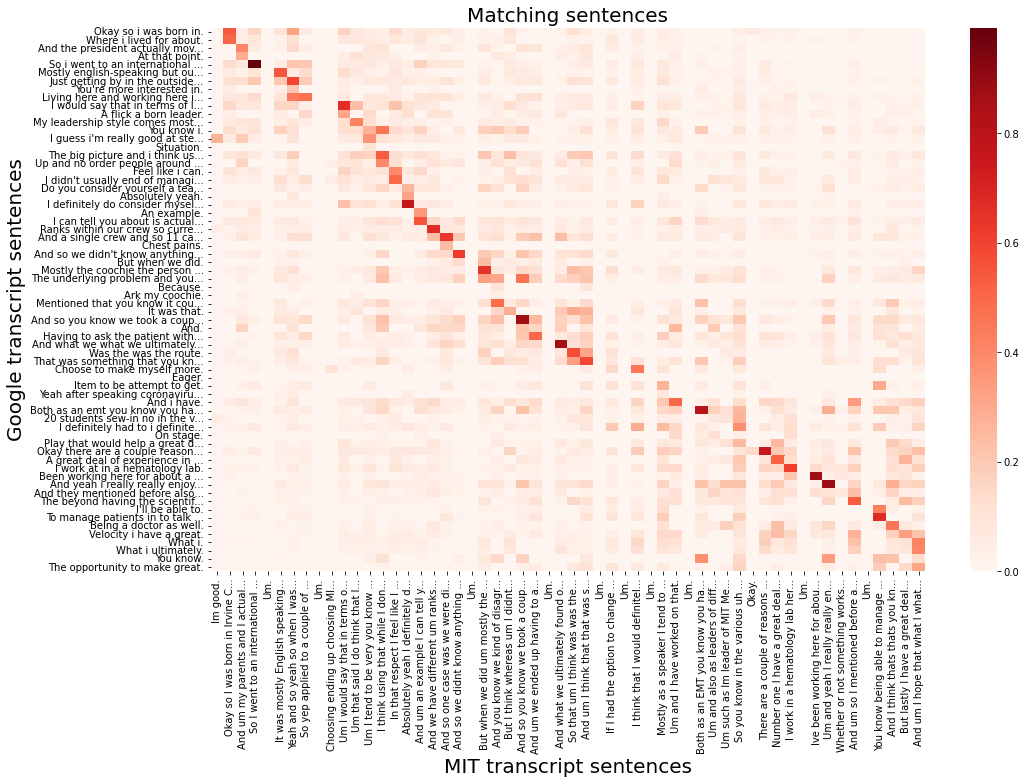

In [ ]:
# example

# index google_sentences # columns transcript_sentences
df, google_sentences, transcript_sentences = match_sentences(transcript=transcript_example, google_sentences=google_example)
plt.figure(figsize=(16,10))

yticklabels = []
for i, sentence in enumerate(google_sentences):
  yticklabels.append(sentence[:30] + (sentence[30:] and '...'))


xticklabels = []
for i, sentence in enumerate(transcript_sentences):
  xticklabels.append(sentence[:30] + (sentence[30:] and '...'))

cmap = sns.color_palette("Reds", as_cmap=True)
#mask=df < 0.25
ax = sns.heatmap(df, xticklabels=xticklabels, yticklabels=yticklabels, cmap=cmap)

ax.set(ylabel='Google transcript sentences',
       xlabel='MIT transcript sentences',
       title='Matching sentences')

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.title.set_size(20)

plt.show()

**Analysis of graph**
- there are some very long sentences in the google transcript 
  -> not every sentence should only be assigned to only one sentence in the MIT transcript
- define a threshold for example 0.4
- assign sentence to the combined timeslot 
- take the len of the sentence into account

In [ ]:
mit_transcript_timestamps_df = pd.DataFrame(index=range(len(transcript_sentences)), columns=['start', 'end'])
google_transcript_timestamps_df = pd.DataFrame(timestamps_example, index=range(len(google_sentences)), columns=['start', 'end'])
mit_transcript_timestamps_df.set_index(pd.Index(transcript_sentences))

# Create timestamps for MIT sentences
- calculate timestamps for matching sentences 
- fill the sentences that found no match (short sentences)


In [ ]:
# match sentences

def timestamps_for_mit_transcription(similarity_dataframe, google_sentences, transcript_sentences, timestamps, max_sentences = 5, threshold = 0.3): 
  mit_transcript_timestamps_df = pd.DataFrame(index=range(len(transcript_sentences)), columns=['start', 'end'])
  google_transcript_timestamps_df = pd.DataFrame(timestamps, index=range(len(google_sentences)), columns=['start', 'end'])

  for i, transcript_sentence in enumerate(transcript_sentences):
    similar_sentences_ids_plus_values = similarity_dataframe[similarity_dataframe[i] >= threshold][i].nlargest(max_sentences)
    similar_sentences_google_ids = similar_sentences_ids_plus_values.index.sort_values()

    if len(similar_sentences_google_ids) >= 1:
      mit_transcript_timestamps_df.iloc[i]['start'] = google_transcript_timestamps_df.iloc[similar_sentences_google_ids[0]]['start']
      mit_transcript_timestamps_df.iloc[i]['end'] = google_transcript_timestamps_df.iloc[similar_sentences_google_ids[-1]]['end']

  return mit_transcript_timestamps_df, transcript_sentences

In [ ]:
# fill missing

def fillna_timestamps_mit_transcription(timestamp_transcript_dataframe, transcript_sentences):
  for i in range(1, len(timestamp_transcript_dataframe) + 1):
      if ~np.isnan(timestamp_transcript_dataframe.iat[i - 1, 0]):
        continue
      else:
        start_prev_usefull = 0
        end_prev_usefull = 0
        start_next_usefull = 0
        end_next_usefull = 0

        up = i - 1
        down = i - 1

        # find usefull values below
        while down >= 0:
          if ~np.isnan(timestamp_transcript_dataframe.iat[down, 0]):
            start_prev_usefull = timestamp_transcript_dataframe.iat[down, 0]
            end_prev_usefull = timestamp_transcript_dataframe.iat[down, 1]
            break
          else:
            down -= 1

        # find usefull values above
        while up < len(timestamp_transcript_dataframe):
          if ~np.isnan(timestamp_transcript_dataframe.iat[up, 0]):
            start_next_usefull = timestamp_transcript_dataframe.iat[up, 0]
            end_next_usefull = timestamp_transcript_dataframe.iat[up, 1]
            break
          else:
            up += 1
      
        # error
        assert ~(start_prev_usefull == 0 and start_next_usefull == 0), 'Error: no values in dataframe'
        
        # both values
        if start_prev_usefull > 0 and start_next_usefull > 0:
          if start_next_usefull > end_prev_usefull:
            timestamp_transcript_dataframe.iat[i - 1, 0] = end_prev_usefull
            timestamp_transcript_dataframe.iat[i - 1, 1] = start_next_usefull
          elif start_prev_usefull > end_next_usefull:
            timestamp_transcript_dataframe.iat[i - 1, 0] = start_prev_usefull
            timestamp_transcript_dataframe.iat[i - 1, 1] = end_prev_usefull
          else:
            timestamp_transcript_dataframe.iat[i - 1, 0] = start_prev_usefull
            timestamp_transcript_dataframe.iat[i - 1, 1] = end_next_usefull

        elif start_prev_usefull == 0:
          timestamp_transcript_dataframe.iat[i - 1, 0] = start_next_usefull
          timestamp_transcript_dataframe.iat[i - 1, 1] = end_next_usefull
        elif start_next_usefull == 0:
          timestamp_transcript_dataframe.iat[i - 1, 0] = start_prev_usefull
          timestamp_transcript_dataframe.iat[i - 1, 1] = end_prev_usefull

  timestamp_transcript_dataframe['timestamp'] = timestamp_transcript_dataframe[['start', 'end']].values.tolist()
  output = timestamp_transcript_dataframe['timestamp'].tolist()
  return output

## 5. Apply to all interviews and save

In [ ]:
# similarity scores
google_mit_transcripts['text_similarity_dataframes'] = google_mit_transcripts.apply(lambda x: 
                                                                                    match_sentences(transcript = x['text_remove_interview_signs'], 
                                                                                                    google_sentences = x['google_transcription']), axis=1)
# timestamps
google_mit_transcripts['tmp'] = google_mit_transcripts.apply(lambda x: timestamps_for_mit_transcription(x['text_similarity_dataframes'][0], 
                                                                        x['text_similarity_dataframes'][1],
                                                                        x['text_similarity_dataframes'][2],
                                                                        x['timestamps']), axis=1)
# fill missing
google_mit_transcripts['tmp1'] = google_mit_transcripts.apply(lambda x: fillna_timestamps_mit_transcription(x['tmp'][0], 
                                                                        x['tmp'][1]), axis=1)

google_mit_transcripts['tokenized_sentences'] = google_mit_transcripts['text_remove_interview_signs'].apply(sent_tokenize)
# save
df[['Participant', 'tokenized_sentences' , 'tmp1']].to_csv('drive/MyDrive/Colab Notebooks/XAI/audio_split/Code/mit_transcription_timestamps.csv')